In this post we will explore the most important parameters of Sklearn KNeighbors classifier and how they impact our model in term of overfitting and underfitting.

This classifier implements a k-nearest neighbors vote.

We will use the Titanic Data from kaggle. For the sake of this post, we will perform as little feature engineering as possible as it is not the purpose of this post.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

Load train data

In [2]:
# get titanic & test csv files as a DataFrame
train = pd.read_csv("input/train.csv")
print train.shape

(891, 12)


In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Check for missing values

In [4]:
#Checking for missing data
NAs = pd.concat([train.isnull().sum()], axis=1, keys=['Train'])
NAs[NAs.sum(axis=1) > 0]

,Train
Age,177
Cabin,687
Embarked,2


We will remove 'Cabin', 'Name' and 'Ticket' columns as they require some processing to extract useful features

In [5]:
# At this point we will drop the Cabin feature since it is missing a lot of the data
train.pop('Cabin')

# At this point names don't affect our model so we drop it
train.pop('Name')

# At this point we drop Ticket feature
train.pop('Ticket')

train.shape

(891, 9)

Fill the missing age values by the mean value

In [6]:
# Filling missing Age values with mean
train['Age'] = train['Age'].fillna(train['Age'].mean())

Fill the missing 'Embarked' values by the most frequent value

In [7]:
# Filling missing Embarked values with most common value
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])

In [8]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


'Pclass' is a categorical feature so we convert its values to strings

In [9]:
train['Pclass'] = train['Pclass'].apply(str)

Let's perform a basic one hot encoding of categorical features

In [10]:
# Getting Dummies from all other categorical vars
for col in train.dtypes[train.dtypes == 'object'].index:
    for_dummy = train.pop(col)
    train = pd.concat([train, pd.get_dummies(for_dummy, prefix=col)], axis=1)

In [11]:
train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,3,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,4,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,5,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [12]:
labels = train.pop('Survived')

For testing, we choose to split our data to 75% train and 25% for test

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.25)

Let's first fit a decision tree with default parameters to get a baseline idea of the performance

In [14]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

In [15]:
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [16]:
y_pred = model.predict(x_test)

We will AUC (Area Under Curve) as the evaluation metric. Our target value is binary so it's a binary classification problem. AUC is a good way for evaluation for this type of problems

In [17]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.51680529621456472

## n_neighbors

n_neighbors represents the number of neighbors to use for kneighbors queries

In [18]:
neighbors = list(xrange(1,30))

In [19]:
train_results = []
test_results = []
for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(x_train, y_train)
    
    train_pred = model.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = model.predict(x_test)
    
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

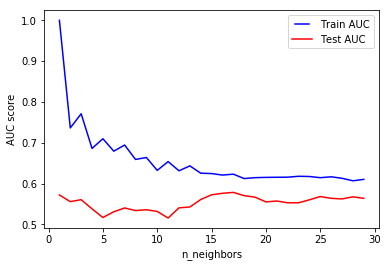

In [20]:
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(neighbors, train_results, 'b', label="Train AUC")
line2, = plt.plot(neighbors, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('n_neighbors')
plt.show()

Using n_neighbors=1 means each sample is using itself as reference, that's an overfitting case. For our data, increasing the number of neighbors improves the test scores

## p in L_p distance

This is the power parameter for the Minkowski metric. When p=1, this is equivalent to using manhattan_distance(l1), and euliddean_distance(l2) for p=2. For arbitrary p, minkowski distance (l_p) is used

In [21]:
distances = [1, 2, 3, 4, 5]

In [22]:
train_results = []
test_results = []
for p in distances:
    model = KNeighborsClassifier(p=p)
    model.fit(x_train, y_train)
    
    train_pred = model.predict(x_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = model.predict(x_test)
    
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

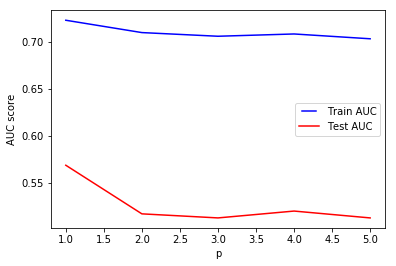

In [23]:
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(distances, train_results, 'b', label="Train AUC")
line2, = plt.plot(distances, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('p')
plt.show()

In most cases, the choice is always between l1 and l2 but it's interesting to see the results of higher minkowski distances. For our data, using l1 seems to better than l2 and other l_p distances